# Trajectory Prediction 
- Team KaAi

###  1. Import module 

In [29]:
# 1. Import Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import unicodedata
import string
import re
import time
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

### 2. Set up device to GPU 

In [30]:
# 2. Check Device 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [31]:
# For using visdom module finding out the ip on my computer.
import socket

def ipcheck():
	return socket.gethostbyname(socket.getfqdn())

print(ipcheck())

127.0.1.1


In [32]:
# Visualization module
import visdom
!python -m visdom.server # open visdom server
vis = visdom.Visdom() # An error occurs when the visdom server is off.

/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/site-packages/visdom/server.py:39: DeprecationWarning: zmq.eventloop.ioloop is deprecated in pyzmq 17. pyzmq now works with default tornado and asyncio eventloops.
  ioloop.install()  # Needs to happen before any tornado imports!
Checking for scripts.
It's Alive!
Traceback (most recent call last):
  File "/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/site-packages/visdom/server.py", line 1922, in <module>
    download_scripts_and_run()
  File "/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/site-packages/visdom/server.py", line 1918, in download_scripts_and_run
    main()
  File "/home/kaai/anaconda3/envs/kaggle3rd/lib/python3.8/site-packages/visdom/server.py", line 1

Setting up a new session...


### 3.  Load dataset and dataloader for training

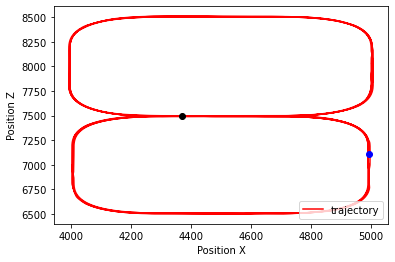

Sum Trajectory: 11944 Average Trajectory: 11944.0
std, mean, rgs textfile saved!!!
length_traj :  11944
train_loader_traj :  75


75

In [33]:
# 3. Prepare DataSet & DataLoader
# ▶▶ Load data from 'prepare_data.py'
import importlib
import prepare_data
importlib.reload(prepare_data)
from prepare_data import *
# The starting point : black ★  ---------------  ★ The destination point  : blue  #

length = 40 
# ▶▶ Each trajectory is combined into length data.

predict_length = 30 
# 10 Hz, so if the predict_length is 30, 3 seconds

batch_size = 128 

Training_generator, Test, Valid, WholeSet = get_dataloader(batch_size,length,predict_length)

len(Training_generator) # training_data_size / batch_size

### 4. Define model 

In [34]:
# 4. Define UB-LSTM Model
class TraPred(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,batch_size, dropout=0.5):
        super(TraPred, self).__init__()
        
        self.batch_size = batch_size # Batch size
        self.hidden_size = hidden_size # The number of nodes in the LSTM hidden layer. 
        self.num_layers = 2 # The number of LSTM hidden layers.

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,num_layers=self.num_layers,bidirectional=False,batch_first=True,dropout =dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2,num_layers=self.num_layers,bidirectional=True,batch_first=True,dropout =dropout)
    
        self.fc0 = nn.Linear(hidden_size,hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2,int(hidden_size/2))
        self.in2out = nn.Linear(input_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2) ,output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        bilstm_out,_= self.bilstm(self.in2bilstm(input))
        lstm_out,_= self.lstm(self.in2lstm(input))
        out = self.tanh(self.fc0(lstm_out+bilstm_out))
        out = self.tanh(self.fc1(out))
        out =  out + self.in2out(input)
        output = self.fc2(out)# range [0 -> 1]
        return output


### 5. Define train function

In [35]:
# 5. Function : train() code
# trajectory predintion train code
# If you don't want visualization using the visdom module, 
# please remove the code related to visdom.
def trainIters(encoder, epoches,learning_rate=0.0001,print_every=7):

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer,mode='min',
factor=0.1, patience=120,verbose=True,threshold=0.0001,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-015)
# The ReduceLROnPlatea function reduces the learning rate by factor times if val_loss is not improved and stagnated.

    tit = '_'+str(batch_size)+'_'+str(learning_rate)
    loss_plt = vis.line(Y=torch.Tensor(1,2).zero_(), opts = dict(title = 'loss'+tit,legend=['train_loss','valid_loss'],showlegend=True))
    criterion = nn.MSELoss()
    loss_min = np.inf
    train_losses =[]
    valid_losses =[]
    encoder.train() # Model training mode
    for e in range(1, epoches + 1):
        train_loss = []
        for batch_i,(local_batch, local_labels) in enumerate(Training_generator):
            # local_batch, local_labels : torch.Size([batch_size, length, input/output features])
            
            encoder.zero_grad() 

            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            
            predY = encoder(local_batch)           
            loss = criterion(predY,local_labels).to(device) # Calculate loss 
            loss.backward() # backpropagation
            encoder_optimizer.step()
            train_loss.append(loss.item())
            
            if batch_i % print_every == 0:     
                valid_loss = []
        
                encoder.eval() # Model evaluation mode
                for x,y in Valid:
                    x,y = x.to(device),y.to(device)
                    predict = encoder(x) 
                    loss_valid = criterion(predict,y) 
                    valid_loss.append(loss_valid.item())
                   
                    
                encoder.train() # Model training mode
                train_loss_mean = np.mean(train_loss)
                valid_loss_mean = np.mean(valid_loss)
                train_losses.append(train_loss_mean)
                valid_losses.append(valid_loss_mean)
                scheduler.step(valid_loss_mean)
                loss_vis = torch.Tensor([[loss,loss_valid]])
                print("Epoch:{}/{},Step:{}/{}".format(e,epoches,batch_i,len(Training_generator)),
                  "Train_Loss:{},Valid_Loss: {}".format(train_loss_mean,valid_loss_mean))
                vis.line(Y=torch.Tensor(loss_vis), X=torch.Tensor([e]), win=loss_plt, update='append')
                if valid_loss_mean < loss_min : # Save model if the value of valid_loss is less than the value of minimum loss.                    
                    print("valid_loss decrease!!!save the model.")
                    loss_min = valid_loss_mean
                    torch.save(encoder.state_dict(),'model/trajectory_predict_UB-LSTM.pt')
                if e % 100 == 0:
                    torch.save(encoder.state_dict(),f'model/trajectory_predict_UB-LSTM_{e}.pt')
    plt.plot(train_losses,color = 'r',label = 'Train_Loss')
    plt.plot(valid_losses,color = 'g',label = 'Valid_Loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/trajectory_loss_improve1_lsy_44_4_30.svg',dpi=600)

### 6. Train

In [ ]:
# 6. training
train_iter = iter(Training_generator)
x, y = train_iter.next()
print(x.shape, y.shape)
hidden_size = 256
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
# TraPred(input_features, output_features, hidden_size, batch_size)

from time import time
TRAN_TAG = True
if TRAN_TAG:
    if path.exists("model/trajectory_predict_UB-LSTM.pt"):
        # If there's a model that's already been trained, bring the parameters of the model.
        Prednet.load_state_dict(torch.load('model/trajectory_predict_UB-LSTM.pt'))        
    else:
        Prednet = Prednet.double() # Change it to double type.
        Prednet = Prednet.to(device)
        start = time()
        
        trainIters(Prednet, 2000,0.001,20) # train(model, epochs=1000, lr=0.001, print_every=20)  
        print('Training time is:',time()-start,'s')

torch.Size([128, 40, 25]) torch.Size([128, 40, 4])
Epoch:1/2000,Step:0/75 Train_Loss:0.5507840917414307,Valid_Loss: 1.165457514724893
valid_loss decrease!!!save the model.
Epoch:1/2000,Step:20/75 Train_Loss:0.9597269775199344,Valid_Loss: 0.9791066269526318
valid_loss decrease!!!save the model.
Epoch:1/2000,Step:40/75 Train_Loss:0.8796689847662689,Valid_Loss: 0.7145146180755919
valid_loss decrease!!!save the model.
Epoch:1/2000,Step:60/75 Train_Loss:0.7450203112978578,Valid_Loss: 0.48467094546375533
valid_loss decrease!!!save the model.
Epoch:2/2000,Step:0/75 Train_Loss:0.45823436725760713,Valid_Loss: 1.4507939872531967
Epoch:2/2000,Step:20/75 Train_Loss:0.5269398934654362,Valid_Loss: 0.3799868090698396
valid_loss decrease!!!save the model.
Epoch:2/2000,Step:40/75 Train_Loss:0.44295443244145777,Valid_Loss: 0.31524865707175015
valid_loss decrease!!!save the model.
Epoch:2/2000,Step:60/75 Train_Loss:0.3808920127915313,Valid_Loss: 0.3866729589187039
Epoch:3/2000,Step:0/75 Train_Loss:0.0448

Epoch:21/2000,Step:60/75 Train_Loss:0.007328920809558012,Valid_Loss: 0.010292074426447903
valid_loss decrease!!!save the model.
Epoch:22/2000,Step:0/75 Train_Loss:0.003826694136043279,Valid_Loss: 0.011275666029715723
Epoch:22/2000,Step:20/75 Train_Loss:0.006541381379927425,Valid_Loss: 0.020488864550662268
Epoch:22/2000,Step:40/75 Train_Loss:0.006751905384849635,Valid_Loss: 0.018673318099419217
Epoch:22/2000,Step:60/75 Train_Loss:0.006810881300604919,Valid_Loss: 0.010459623072771158
Epoch:23/2000,Step:0/75 Train_Loss:0.008343502071462694,Valid_Loss: 0.012000860020092907
Epoch:23/2000,Step:20/75 Train_Loss:0.006592712867845065,Valid_Loss: 0.024115306939061474
Epoch:23/2000,Step:40/75 Train_Loss:0.008348998212782314,Valid_Loss: 0.01356152767215787
Epoch:23/2000,Step:60/75 Train_Loss:0.007880519390528069,Valid_Loss: 0.012856841634627691
Epoch:24/2000,Step:0/75 Train_Loss:0.011907381847900746,Valid_Loss: 0.011420348215530677
Epoch:24/2000,Step:20/75 Train_Loss:0.009228811219068073,Valid_Los

### 7. Optimization function for better prediction

In [66]:
# 7. X, Y값 계산
def calcu_XY(predY):
    '''
    deltaY = v0*delta_t + 0.5* a *delta_t^2
    a = (v - v0)/delta_t
    vo
    '''
    vels = predY[:,:,0:2] 
    rst_xy = np.zeros(predY[:,:,:4].shape)
    rst_xy[:,:-predict_length,:] = predY[:,:-predict_length,:4]
    # index 0,1 of predY : speed 
    # index 2,3 of predY : location
    
    delta_t = 0.1 # Data were collected at intervals of 0.1 second.
    
    for i in range(predict_length):
        a = (vels[:,-(predict_length-i),:] - vels[:,-(predict_length+1-i),:])/delta_t
        delta_xy = vels[:,-(predict_length-i),:]*vels[:,-(predict_length-i),:]-vels[:,-(predict_length+1-i),:]*vels[:,-(predict_length+1-i),:]
        delta_xy = delta_xy/(2*a)
        # Optimize to increase accuracy.
        rst_xy[:,-(predict_length-i),2:4] = rst_xy[:,-(predict_length+1-i),2:4] + delta_xy
    return rst_xy

### 8. Model evaluation

In [67]:
# 8. Evaluation

# ▶▶ trajectory prediction evaluation code
def Eval_net(encoder,optmizer=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres, MSE_rsts = [],[]
    for local_batch, local_labels in Test:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        predY = encoder(local_batch) 
        
        print('local_batch.shape : ',local_batch.shape)

        test_loss = criterion(predY,local_labels)
        
        loss.append(test_loss.item()) 
                
        # Read the .txt file and proceed with the inverse normalization
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        
        predY = (predY*(rg*std)+mn).detach().cpu()
        print('predY type : ', type(predY))
        
        pY = np.array(predY)
        
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()

        
        Y = np.array(local_labels)

        
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
        
        rst_xy = calcu_XY(pY) # The x and y values calculated using the optimization function.
        
        #  Plot prediction of 20 paths
        if n_trajectory_batch > 20: 
            break
        for i in range(1):
            real_predict = torch.from_numpy(Y[i,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[i,-predict_length-1:,2:4])
            pre_predict = torch.from_numpy(pY[i,-predict_length-1:,2:4])
            
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
            
            print("MSE pre:",MSE_pre.item())
            print("MSE RST:",MSE_rst.item())
            
            MSE_pres.append(MSE_pre.item())
            MSE_rsts.append(MSE_rst.item())
            # HISTORY TRAJECTORY 
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optmizer:
            # PREDICTION TRAJECTORY
                plt.plot(rst_xy[i,-predict_length-1:,2],rst_xy[i,-predict_length-1:,3],'b',label=" prediction trajectory via optimizing")
            # REAL TRAJECTORY 
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            
            if optmizer:
                plt.savefig("image/trajectory_output_optimization/trajectory_UB-LSTM_{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/trajectory_UB-LSTM_{}.svg".format(n_trajectory_batch),dpi=600)
                
        plt.show()
        print('Test loss:',test_loss.item())
    print('average MSE_pre:',np.mean(MSE_pres))
    print('average MSE_rst:',np.mean(MSE_rsts))
    print('average loss:',np.mean(loss))

### 9. Evaluate

local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 25.48340335607398
MSE RST: 0.485222822313343


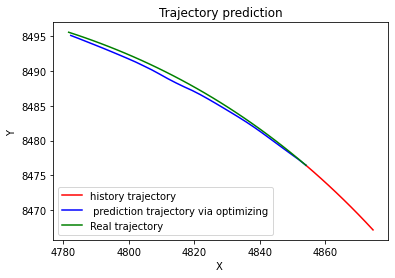

Test loss: 0.0002490950421122255
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 9.110128293891378
MSE RST: 0.41787788175414076


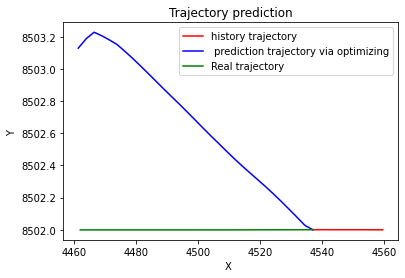

Test loss: 0.0004766148759345453
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 2.9727906637483947
MSE RST: 0.4294987576072576


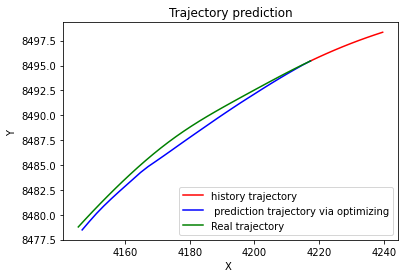

Test loss: 0.0019749865648484807
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 12.568615504975527
MSE RST: 1.2242319914301516


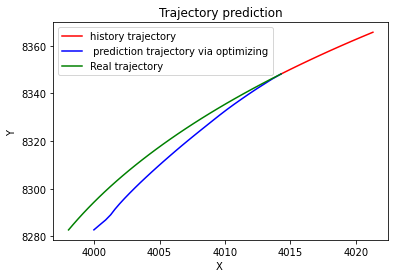

Test loss: 0.0006892019524633078
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 0.8144541014423766
MSE RST: 2.238313708502225


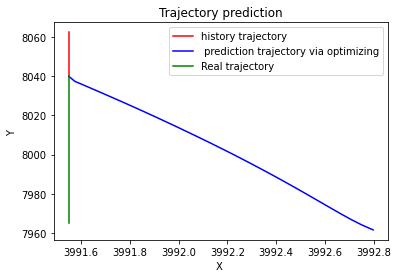

Test loss: 0.0005606991675975873
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 12.835950188727189
MSE RST: 0.16060269726214033


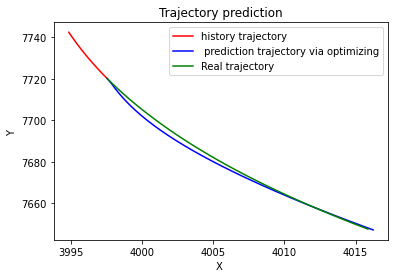

Test loss: 0.0006154625549392486
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 3.1405080374177885
MSE RST: 3.048092530230101


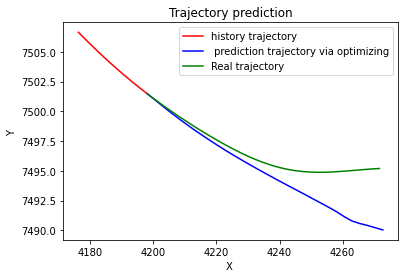

Test loss: 0.0009420973520073008
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 2.93687667242247
MSE RST: 2.3947516006490694


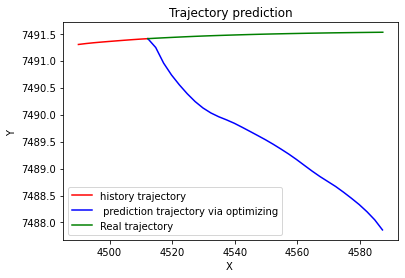

Test loss: 0.0007095674419620372
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 59.962111778428834
MSE RST: 2.4125318780761327


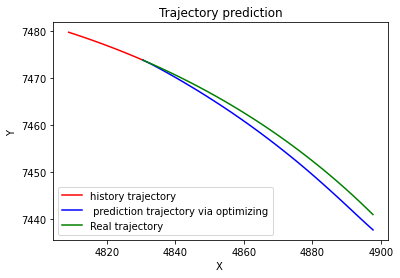

Test loss: 0.0007161967748399158
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 2.8275625107660534
MSE RST: 0.08521703652454661


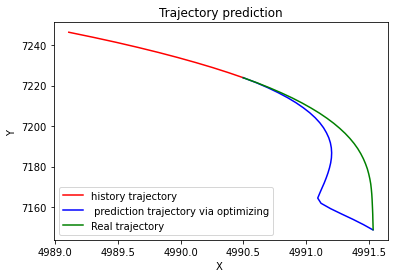

Test loss: 0.0011478475206268344
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 4.8236018206778155
MSE RST: 2.2424546776014247


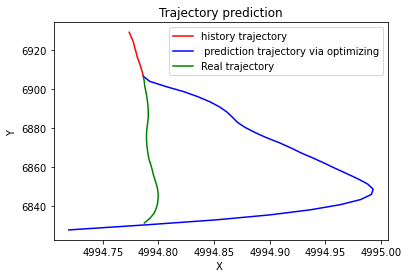

Test loss: 0.0006976059628477664
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 49.79108505146267
MSE RST: 2.484012285281181


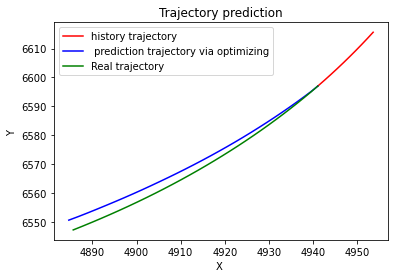

Test loss: 0.00045136061419359853
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 7.6685716185513995
MSE RST: 0.646274584514171


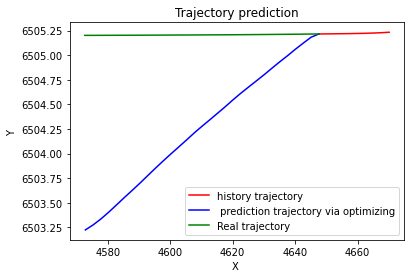

Test loss: 0.00044943235086590647
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 4.423862217547937
MSE RST: 1.7109969010855388


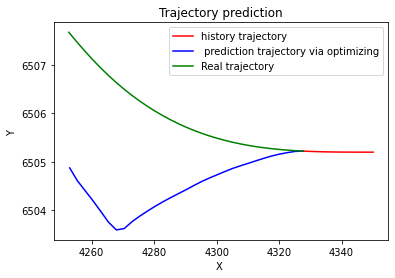

Test loss: 0.0004893633673374035
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 4.300453868392486
MSE RST: 0.17448024929507627


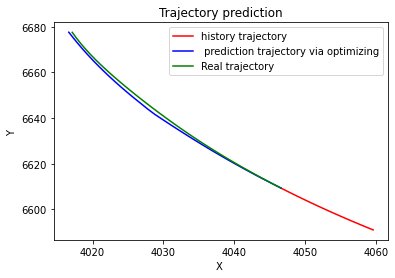

Test loss: 0.0005440383327620944
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 6.238373643689096
MSE RST: 2.1931818582119686


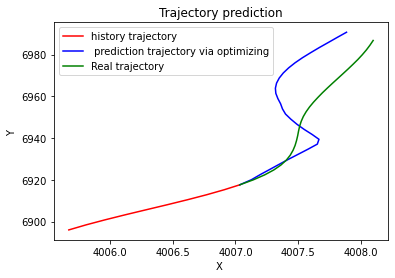

Test loss: 0.0004263022716306137
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 5.656294485732637
MSE RST: 0.8103143249553706


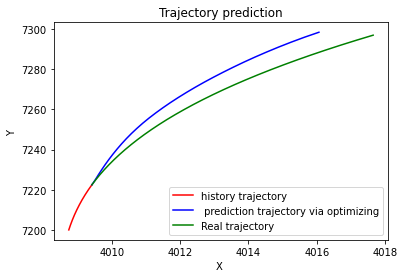

Test loss: 0.0008834369242353186
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 3.394825909377021
MSE RST: 0.7711386564719002


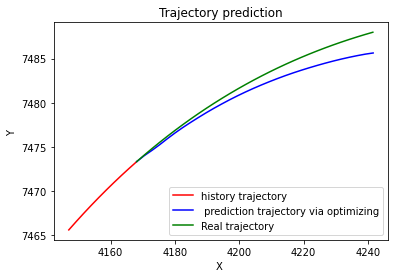

Test loss: 0.00033899853023658166
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 1.304269212423748
MSE RST: 0.7453097748740712


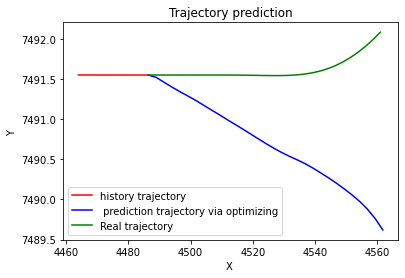

Test loss: 0.0008246410603780216
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
MSE pre: 6.21488189142744
MSE RST: 0.5306002891807735


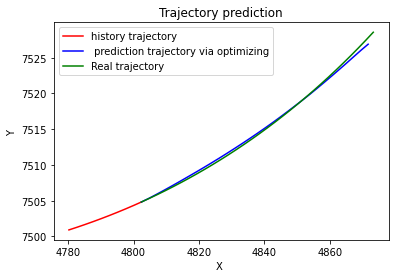

Test loss: 0.0006434230923088924
local_batch.shape :  torch.Size([128, 40, 25])
predY type :  <class 'torch.Tensor'>
average MSE_pre: 11.323431041358813
average MSE_rst: 1.2602552252910293
average loss: 0.0007026880173582195


In [68]:
# 9. Model Evaluate

hidden_size = 256
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
# TraPrd(input_size, output_size, hidden_size, batch_size)

Prednet.load_state_dict(torch.load('/home/kaai/jupyter_notebook/LAST_CODE/model/trajectory_predict_UB-LSTM.pt'))
# Brings up the parameters of the saved model.

Prednet = Prednet.double()
# Change it to double type.

Prednet = Prednet.to(device)
# Set up model to device type

Prednet.eval() 
# Model evaluation mode

Eval_net(Prednet, True) 
# Model evaluation

### 10. Define predict function

In [69]:
# 10. Function : predict()

# trajectory prediction predict code
def predict(model,test_load,n,optimizer=False):
    test = iter(test_load)
    
    x,y =  test.next()
    x,y = x.to(device),y.to(device)    
 
    predY = model(x)
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    
    predY = (predY*(rg*std)+mn).detach().cpu() 
    pY = np.array(predY)
    
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    
    

    rst_xy = calcu_XY(pY)
    
    
    real_predict = torch.from_numpy(Y[:n,-predict_length-1:,2:4])
    rst_predict = torch.from_numpy(rst_xy[:n,-predict_length-1:,2:4])
    pre_predict = torch.from_numpy(pY[:n,-predict_length-1:,2:4])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE :",MSE_rst.item())
    
    # Plot history trajectory, prediction trajectory via optimizing and real trajectory 
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimizer:
        plt.plot(rst_xy[:n,-predict_length-1:,2][0],rst_xy[:n,-predict_length-1:,3][0],'b',label="prediction trajectory via optimizing")
#     plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.legend()
    if optimizer:
        plt.savefig("image/trajectory_output_optimization/trajectory_alone_UB-LSTM.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/trajectory_alone_UB-LSTM.svg",dpi = 600)
    
    print("Test Loss:",test_loss.item())

### 11. Model test

torch.Size([128, 40, 25])
MSE : 0.485222822313343
Test Loss: 0.0002490950421122255


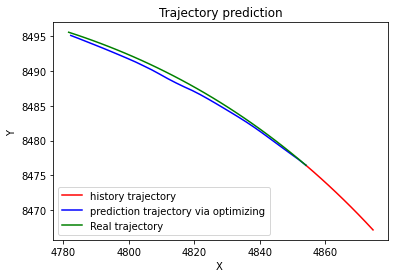

In [70]:
# 11. Test

hidden_size = 256
print(x.shape)
Prednet = TraPred(x.shape[2], y.shape[2], hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('/home/kaai/jupyter_notebook/LAST_CODE/model/trajectory_predict_UB-LSTM.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval() # Model eevaluation mode


predict(Prednet, Test, 1, True) # Predict Model